# Getting started - a simple network diffusion

This introductory example explains the use of the basic types and constructors in NetworkDynamics.jl by modeling a simple diffusion on an undirected network.

## Theoretical background

Diffusion processes are relevant for phenomena as diverse as heat conduction, electrical currents, and random walks. Generally speaking they describe the tendency of systems to evolve towards a state of equally distributed heat, charge or concentration. In such system the local temperature (or concentration) changes according to its difference with its neighborhood, i.e. the temperature gradient.

Let $g$ be a graph with $N$ nodes and adjacency matrix $A$. Let $v = (v_1, \dots, v_n)$ be a vector of (abstract) temperatures or concentrations at each node $i = 1, \dots, N$. Then the rate of change of state $v_i$ is described by its difference with its neighbors and we obtain the following ordinary differential equation

\begin{equation}
\dot v_i = - \sum_{i=1}^N A_{ij} (v_i - v_j).
\end{equation}

The sum on the right hand side plays the role of a (discrete) gradient. If the temperature at node $i$ is higher than at its neighboring node $j$ it will decrease along that edge.

## Modeling diffusion in NetworkDynamics.jl

From the above considerations we see that in this model the nodes do not have any internal dynamics - if a node was disconnected from the rest of the network its state would never change, since then $A_{ij} = 0 \; \forall j$ and hence $\dot v_i = 0$. This means that the evolution of a node depends only on the interaction with its neighbors. In NetworkDynamics.jl, interactions with neighbors are described by equations for the edges. 

In [1]:
function diffusionedge!(e, v_s, v_d, p, t)
    # usually e, v_s, v_d are arrays, hence we use the broadcasting operator .
    e .= v_s - v_d 
    nothing
end

diffusionedge! (generic function with 1 method)

The function `diffusionedge!` takes as inputs the current state of the edge `e`, its source vertex `v_s`, its destination vertex `v_d`, a vector of parameters `p` and the time `t`. In order to comply with the syntax of NetworkDynamics.jl we always have to define functions for static edges with exactly these arguments, eventhough we do not need `p` and `t` for the diffusion example. 

`diffusionedge!` is called a **mutating** function, since it modifies (or *mutates*) one of its inputs, namely the edge state `e`. As a convention in julia names of mutating functions end with an `!`. The use of mutating functions reduces allocations and thereby speeds up computations. After the function call the edge's value `e` equals the difference between its source and its destination vertex (i.e. the discrete gradient along that edge).

The contributions of the different edges are then summed up in each vertex.

In [2]:
function diffusionvertex!(dv, v, edges, p, t)
    # usually v, edges are arrays, hence we use the broadcasting operator .
    dv .= 0.
    for e in edges
        dv .+= e
    end
    nothing
end    

diffusionvertex! (generic function with 1 method)

Just like above the input arguments `v, edges, p, t` are mandatory for the syntax of vertex functions. The additional input `dv` corresponding to the derivative of the vertex' state is mandatory for vertices described by ordinary differential equations.

For undirected graphs, the `edgefunction!` specifies the coupling from a source- to a destination vertex. The contributions of the connected edges are added to the destination of each edge, as defined in the `diffusionvertex!` function in the for loop.

## Constructing the network

With the preliminaries out of the way, it only takes a few steps to assemble the network dynamics.

In [3]:
using Graphs

N = 20 # number of nodes
k = 4  # average degree
g = barabasi_albert(N, k) # a little more exciting than a bare random graph

{20, 64} undirected simple Int64 graph

The [Barabási–Albert model](https://en.wikipedia.org/wiki/Barab%C3%A1si%E2%80%93Albert_model) generates a scale-free random graph.

In [4]:
using NetworkDynamics

nd_diffusion_vertex = ODEVertex(f = diffusionvertex!, dim = 1)
nd_diffusion_edge = StaticEdge(f = diffusionedge!, dim = 1)

nd = network_dynamics(nd_diffusion_vertex, nd_diffusion_edge, g)

┌ Info: Precompiling NetworkDynamics [22e9dc34-2a0d-11e9-0de0-8588d035468b]
└ @ Base loading.jl:1273


(::DiffEqBase.ODEFunction{true,nd_ODE_Static{SimpleGraph{Int64},Array{Float64,1},Array{Float64,1},ODEVertex{typeof(diffusionvertex!)},StaticEdge{typeof(diffusionedge!)}},LinearAlgebra.UniformScaling{Bool},Nothing,Nothing,Nothing,Nothing,Nothing,Nothing,Nothing,Nothing,Nothing,Array{Symbol,1},Nothing}) (generic function with 7 methods)

**`ODEVertex`** and **`StaticEdge`** are functions wrappers that equip the functions we defined above with additional information like **`dim`** and return objects of type `VertexFunction` and `EdgeFunction`. Then the key constructor **`network_dynamics`** combines them with the topological information contained in the graph **`g`** and returns an **`ODEFunction`** compatible with the solvers of `DifferentialEquations.jl`. The keyword **`dim`** specifies the number of variables at each edge or node.

In [5]:
using OrdinaryDiffEq

x0 = randn(N) # random initial conditions
ode_prob = ODEProblem(nd, x0, (0., 4.))
sol = solve(ode_prob, Tsit5());

We are solving the diffusion problem on the time interval $[0, 4]$ with the `Tsit5()` algorithm, which is recommended  by the authors of `DifferentialEquations.jl` for most non-stiff problems.

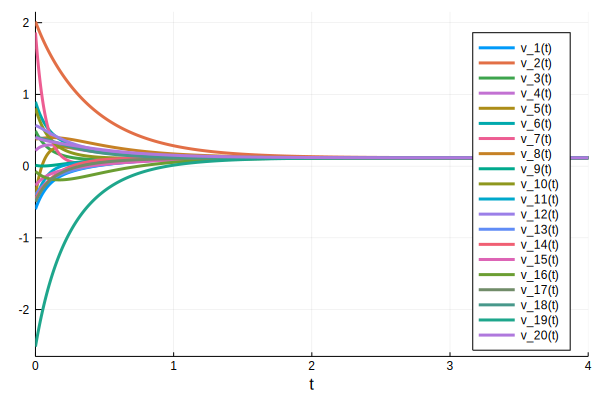

In [6]:
using Plots
plot(sol, vars = syms_containing(nd, "v"))

The plotting is straightforward. The **`vars`** keyword allows us to pass a list of indices or *symbols* specifiying the variables we want to plot. *Symbols* can be thought of as names given to the interal variables of an `ODEFunction`, much like the variables $x$ or $\phi$ in mathematical notation. The default symbol for vertex variables is `v`, however we are free to specify other symbols by passing them to the `ODEVertex` constructor.

`syms_containing` is a helper function that returns all symbols of an `ODEProblem` containg a specific string (or symbol). 

To illustrate a very simple multi-dimensional case, in the following we simulate two independent diffusions on an identical network. The first uses the symbol `x` and is started with initial conditions drawn from the standard normal distribution $N(0,1)$, the second uses the symbol `ϕ` with squared standard normal inital conditions. 

The symbols have to be passed with the keyword **`sym`** to `ODEVertex`.

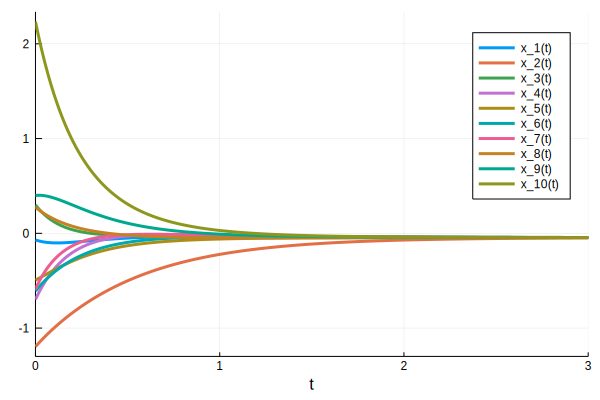

In [16]:
N = 10 # number of nodes
k = 4  # average degree
g = barabasi_albert(N, k) # a little more exciting than a bare random graph

# We will have two indepent diffusions on the network, hence dim = 2
nd_diffusion_vertex_2 = ODEVertex(f = diffusionvertex!, dim = 2, sym = [:x, :ϕ])
nd_diffusion_edge_2 = StaticEdge(f = diffusionedge!, dim = 2)
nd_2 = network_dynamics(nd_diffusion_vertex_2, nd_diffusion_edge_2, g)

x0_2 = vec(transpose([randn(N) randn(N).^2])) # x ~ N(0,1); ϕ ~ x^2 
ode_prob_2 = ODEProblem(nd_2, x0_2, (0., 3.))
sol_2 = solve(ode_prob_2, Tsit5());


# Try plotting the variables ϕ_i yourself. [Type \phi and press TAB]
plot(sol_2, vars = syms_containing(nd_2, "x"))

### Appendix: The network Laplacian $L$

The diffusion equation on a network can be rewritten as

\begin{equation}
\dot v_i  = d_i v_i - \sum_{i=1}^N A_{ij} v_j = d_i v_i - e_i^T A v          
\end{equation}

where $d_i$ is the degree of node $i$ and $e_i^T$ is the $i$-th standard basis vector. Introducing the diagonal matrix $D$ that has the degree of node $i$ in its $i$-th row and the Laplacian matrix $L = D - A$ we arrive at

\begin{equation}
\dot v = e_i^T(D - A) v 
\end{equation}

and finally

$$
\dot v = L v
$$

This is a linear system of ODEs and its solution is a matrix exponential. To study the asymptotic behaviour of the system it suffices to analyze the eigenspectrum of $L$. For this reason $L$ is an important construction in network science.